<img style="float: right;" src="https://upload.wikimedia.org/wikipedia/commons/f/f5/Best_Buy_Logo.svg" alt="bb logo" width="100"/>

<h1><FONT COLOR=#0000E5>BESTBUY </FONT>Televisions</h1>

## 📉 Data Analysis <SPAN STYLE="font-size:18.0pt;font-family:Georgia;">III</span>
### Customer Brand <FONT COLOR=#0000E5>Loyalty</FONT> & <FONT COLOR=#0000E5>Price Sensitivity</FONT>?

In [2]:
import requests
import json
import numpy as np
import pandas as pd
from python_proj.spiders.myAPIkey import getkey

In [3]:
myAPIkey = getkey()
url_head = "https://api.bestbuy.com/v1/products/"  # obtained from https://developer.bestbuy.com/
endpoint = "/viewedUltimatelyBought?"

In [4]:
# Load in list of product sku #s to request
bb = pd.read_csv('python_proj\\bb_clean.csv')
bb = bb.set_index('sku')

In [5]:
### Try test GET ###
sku = '6466022'
url_full = f'{url_head}{sku}{endpoint}apiKey={myAPIkey}'
res = requests.get(url=url_full)
json.loads(res.content)['results'][0]['sku']

'6296602'

# <FONT COLOR=#FF0000> -------------------- API Pull  Code Start-------------------- </FONT>

<FONT COLOR=#FF0000> Takes 10 mins to complete! </FONT><BR>
<FONT COLOR=#FF0000> If not updating request data, skip and import saved csv instead </FONT>

### For each TV, take sku# and make request for <FONT COLOR=#0000E5>Viewed Ultimately Bought</FONT> Products
"Viewed Ultimately Bought Products endpoint can be used to identify the ***top ten products*** that were bought after having viewed the originating product."

In [6]:
# time package for random pausing during API get
import time

In [7]:
#initialte dict to collect all get results
get_full = {}

In [112]:
"""
Takes 10 mins to complete!!
If not updating request data, skip and import saved csv instead
"""

for sku in bb.index:  # replace with [6466022,6414244,6461913,6466017,5900939] or bb.index
    """
    Loop through sku #s and request associated "Viewed Ultimately Bought" product skus
    Save request.content as dictionary (dict.update each request)
    """
    url_full = f'{url_head}{sku}{endpoint}apiKey={myAPIkey}'
    res = requests.get(url=url_full)
    res_content = json.loads(res.content)['results']
    
    # convert response to dict entry
    get_entry = {sku:[res_content[i]['sku'] for i in range(len(res_content))]}
    
    # if response does not return 10 results, fill in NaN up to 10
    dist_from_10 = 10 - len([*get_entry.values()][0])
    [[*get_entry.values()][0].append(np.nan) for i in range(dist_from_10)]
    
    # append dict entry
    get_full.update(get_entry)
    
    time.sleep(np.random.rand()) # random pause between each request

### After API pull, place result dictionary into pd.DataFrame

In [130]:
u_bought = pd.DataFrame.from_dict(get_full).T
u_bought.index.rename('sku',inplace=True)
u_bought.columns = [f'bu{i}' for i in range(1,11)]

In [138]:
# save raw results to csv
u_bought.to_csv('python_proj\\u_bought_raw.csv')

# <FONT COLOR=#FF0000> -------------------- API Pull  Code END-------------------- </FONT>

In [8]:
u_bought = pd.read_csv('python_proj\\u_bought_raw.csv')

In [9]:
# Check results
assert u_bought.shape[0] == bb.shape[0] == 397, "Pulled rows of data should equal # of products in bb_clean (397)"

In [10]:
"""
Prepare data for merge: 
1. melt into single column
2. rename column 
3. drop unused column
4. drop Nan rows
5. ub_sku column dtype should be set to int64 or else merge raises Error
"""
ub_clean = pd.melt(u_bought.reset_index(), id_vars=['sku'],value_vars=[f'bu{i}' for i in range(1,11)])
ub_clean = ub_clean.set_index('sku')
ub_clean.rename(columns={'value':'ub_sku'}, inplace=True)
ub_clean.drop(columns='variable', inplace=True)
ub_clean.dropna(how='any',inplace=True)
ub_clean['ub_sku'] = ub_clean['ub_sku'].astype('int64')
ub_clean.shape  #from 3970 to 3787

(3787, 1)

### Now we can merge with original bb data to obtain the bought TV brand & price

- merge once on index to get originating TV price and manuf
- merge once on ub_sku to get ultimately bought TV price and manuf

In [11]:
ub_final = ub_clean.merge(bb,how='left',left_on='sku',right_on='sku').set_index(ub_clean.index)\
                .drop(columns=['color', 'curved', 'display_type', 'energy_KWh', 'height_nostand',
                               'model_num', 'model_year', 'online_avail', 'refresh_Hz', 'resolution', 
                               'review_average', 'review_count', 'sale_px', 'size_class', 'screen_size', 
                               'smart_capable', 'store_avail', 'sub_class', 'top_class', 'tv_name', 
                               'warranty_yrs', 'weight_nostand', 'width', 'bezel'])
ub_final.rename(columns={'manufacturer':'orig_brand','regular_px':'orig_px'}, inplace=True)

In [12]:
ub_final = ub_final.merge(bb,how='left',left_on='ub_sku',right_on='sku').set_index(ub_clean.index)\
                .drop(columns=['color', 'curved', 'display_type', 'energy_KWh', 'height_nostand',
                               'model_num', 'model_year', 'online_avail', 'refresh_Hz', 'resolution', 
                               'review_average', 'review_count', 'sale_px', 'size_class', 'screen_size', 
                               'smart_capable', 'store_avail', 'sub_class', 'top_class', 'tv_name', 
                               'warranty_yrs', 'weight_nostand', 'width', 'bezel'])
ub_final.rename(columns={'manufacturer':'ub_brand','regular_px':'ub_px'}, inplace=True)

In [13]:
ub_final.ub_brand.loc[ub_final.ub_brand.isna()].shape  # out of 3787, only 86 were not TV purchases

(86,)

In [31]:
ub_pxdiffs = ub_final.groupby('sku').mean()[['orig_px','ub_px']]

In [32]:
ub_pxdiffs['px_diffs'] = ub_pxdiffs.orig_px - ub_pxdiffs.ub_px

In [33]:
ub_pxdiffs.px_diffs.describe()

count      381.000000
mean       418.630367
std       1295.167675
min       -535.000000
25%        -38.000000
50%         23.000000
75%        230.000000
max      11000.000000
Name: px_diffs, dtype: float64

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Get rid of the outliers that browsed \$500 TVs but bought a 10000 dollar TV
- go through and remove outliers ( >3 std)

In [20]:
from python_proj.daniel_tools import rem_outlier

In [37]:
ub_pxdiffs = rem_outlier(ub_pxdiffs,'px_diffs',3)

In [185]:
[ub_pxdiffs.orig_px.median(),ub_pxdiffs.ub_px.median()]

[1199.99, 1093.8909999999998]

In [35]:
n_plots = 10
sns.set_palette(sns.color_palette("cividis", n_plots), n_plots)

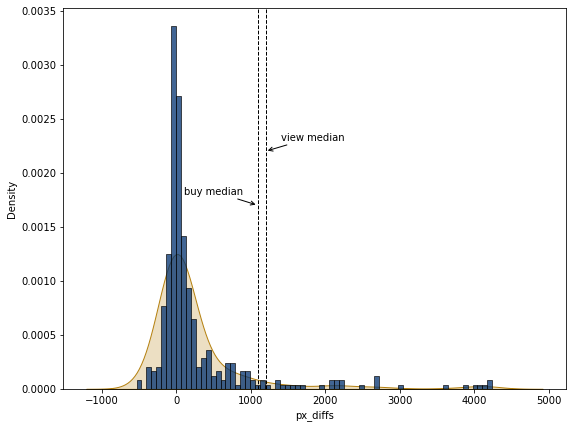

In [240]:
fig = plt.gcf()
fig.set_size_inches(9,7)
ax = sns.histplot(ub_pxdiffs['px_diffs'], stat='density', label='price diff',kde=False)
ax = sns.kdeplot(ub_pxdiffs['px_diffs'], color='#b58110', linewidth=1,fill=True)

#plot viewed TV median price as vertical line
plt.axvline(x=ub_pxdiffs.orig_px.median(),c='black',ls='--',linewidth=1)
ax.annotate('view median', xy=(1200,0.0022), xytext=(1400,0.0023),
            arrowprops=dict(arrowstyle='->', facecolor='#ffe945'),)
plt.axvline(x=ub_pxdiffs.ub_px.median(),c='black',ls='--',linewidth=1)
ax.annotate('buy median', xy=(1090,0.0017), xytext=(100,0.0018),
            arrowprops=dict(arrowstyle='->', facecolor='#ffe945'),)
plt.show()

#### Fairly price sticky, but right skewed with a few opting for more expensive choice

# Check "brand loyalty": i.e. whether ultimately bought TV brand is same as viewed

In [118]:
ub_branddiffs = ub_final.drop(columns=['orig_px','ub_px'])

In [119]:
# Column 'loyal' = TRUE if original TV == ultimately bought TV
ub_branddiffs['loyal'] = ub_branddiffs.orig_brand == ub_branddiffs.ub_brand

In [120]:
# groupby originating TV, and count # of TRUE
ub_branddiffs = ub_branddiffs[ub_branddiffs['loyal']].groupby('sku').count()['loyal'].to_frame()
ub_branddiffs.describe()

,loyal
count,378.000000
mean,5.812169
std,2.120798
min,1.000000
25%,4.000000
50%,6.000000
75%,7.000000
max,10.000000


#### Merge back to main DF, keep only product brand and count of ultimately bought that are of same brand

In [135]:
ub_brandloyal = ub_final.merge(ub_branddiffs,how='inner',on='sku').drop(columns=['ub_sku','orig_px','ub_brand','ub_px'])
ub_brandloyal = ub_brandloyal.groupby('sku').last()

In [136]:
ub_brandloyal

,orig_brand,loyal
sku,,
5900939,Others,2
5900969,Others,4
6202766,Others,1
6280538,TCL,4
6302321,TCL,4
...,...,...
6479660,Others,3
6479707,Others,2
6479709,Others,3


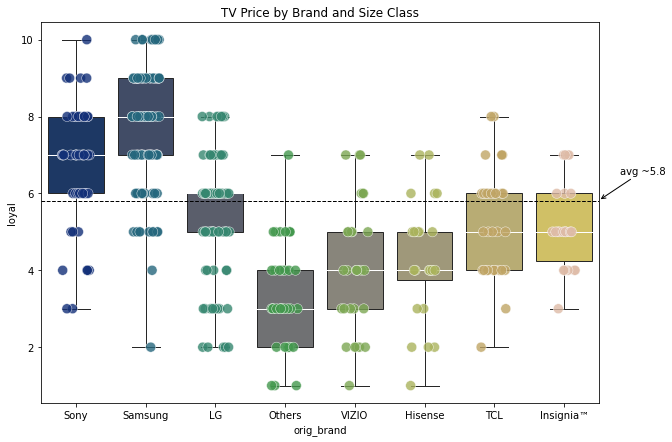

In [204]:
fig = plt.gcf()
fig.set_size_inches(10,7)

# set order of x-axis categories
order = ['Sony', 'Samsung', 'LG', 'Others', 'VIZIO', 'Hisense', 'TCL', 'Insignia™']

# change median line to white
PROPS = {'medianprops':{'color':'white'}}

# Plot scatter over boxplot
ax = sns.boxplot(data = ub_brandloyal, x='orig_brand', y='loyal',
                order=order, palette='cividis', linewidth=1, whis=np.inf, **PROPS)\
                .set_title('TV Price by Brand and Size Class')
ax = sns.stripplot(data = ub_brandloyal, x='orig_brand', y='loyal',
                   order=order, size=10, jitter=0.2,
                   palette='gist_earth', linewidth=0.5, edgecolor='w', alpha=0.8)
plt.axhline(y=ub_brandloyal.loyal.mean(),c='black',ls='--',linewidth=1)
ax.annotate('avg ~5.8', xy=(7.5,5.82), xytext=(7.8, 6.5),
            arrowprops=dict(arrowstyle='->', facecolor='#ffe945'),)
plt.show()

In [140]:
ub_brandloyal.loyal.mean()

5.8121693121693125